# What is the Project?
- This project is a regression analysis with the goal of prediction on the 3 major powerlifting lifts: Squats, Deadlifts, and Bench Press. 
- To accomplish this goal, first the dataset will be cleaned, and then 3 seperate models will be created for each lift. I will use Linear Regression as a baseline, and then create Random Forest models to see if those perform better.  
- As a powerlifter myself, though not a competitive one, it would be really neat to see wto see if it's possible to build an accurate model for powerlifting.

### Dataset Citation - MLA

“OpenPowerlifting Group / Openpowerlifting · GITLAB.” GitLab, https://gitlab.com/openpowerlifting/opl-data. 

Dm, H. “Powerlifting Dataset.” Kaggle, 11 Apr. 2023, https://www.kaggle.com/datasets/docgenki/powerlifting-dataset. 

# About the Dataset

This dataset is from The OpenPowerlifting Project on Gitlab. It is a free open source dataset that includes 41 features on powerlifting, with some being demographic information, recorded lifts, and the scoring metrics on those lifts. 
- The dataset has 17 categorical features and 24 numerical features
- The most key information for my analysis is the best lift for deadlift, squat, and bench press. The demographic information will also be very helpful. 
- There are over 2,000,000 records in this dataset.

In [378]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [379]:
# Read in data
liftdata = pd.read_csv('openpowerlifting_data.csv', header = 0, low_memory = False)

In [380]:
print(liftdata.dtypes)

Name                 object
Sex                  object
Event                object
Equipment            object
Age                 float64
AgeClass             object
BirthYearClass       object
Division             object
BodyweightKg        float64
WeightClassKg        object
Squat1Kg            float64
Squat2Kg            float64
Squat3Kg            float64
Squat4Kg            float64
Best3SquatKg        float64
Bench1Kg            float64
Bench2Kg            float64
Bench3Kg            float64
Bench4Kg            float64
Best3BenchKg        float64
Deadlift1Kg         float64
Deadlift2Kg         float64
Deadlift3Kg         float64
Deadlift4Kg         float64
Best3DeadliftKg     float64
TotalKg             float64
Place                object
Dots                float64
Wilks               float64
Glossbrenner        float64
Goodlift            float64
Tested               object
Country              object
State                object
Federation           object
ParentFederation    

## Removing non-useful columns for analysis
- Having prior knowledge of powerlifting allows me to remove some columns that would inherently cause overfitting.
- Dots, Wilks, Glossbrenner, and Goodlift are all scores applied to lifts that have been completed. These should be removed.
- Place fits the same idea, as the lifters are only placed after the competition portion is over.
- Since the goal is predicting the best lift, the individual lift results can be removed for each of the 3 major lifts.
- Name can also be removed, and TotalKg as well since this is a summation of the 3 lifts.

In [381]:
drop = ['Name', 'Squat1Kg','Squat2Kg', 'Squat3Kg', 'Squat4Kg', 'Bench1Kg','Bench2Kg', 'Bench3Kg', 'Bench4Kg', 'Deadlift1Kg', 'Deadlift2Kg','Deadlift3Kg', 'Deadlift4Kg', 'TotalKg', 'Place', 'Dots', 'Wilks', 'Glossbrenner', 'Goodlift']
liftdata = liftdata.drop(drop, axis = 1)

In [382]:
liftdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2881835 entries, 0 to 2881834
Data columns (total 22 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Sex               object 
 1   Event             object 
 2   Equipment         object 
 3   Age               float64
 4   AgeClass          object 
 5   BirthYearClass    object 
 6   Division          object 
 7   BodyweightKg      float64
 8   WeightClassKg     object 
 9   Best3SquatKg      float64
 10  Best3BenchKg      float64
 11  Best3DeadliftKg   float64
 12  Tested            object 
 13  Country           object 
 14  State             object 
 15  Federation        object 
 16  ParentFederation  object 
 17  Date              object 
 18  MeetCountry       object 
 19  MeetState         object 
 20  MeetTown          object 
 21  MeetName          object 
dtypes: float64(5), object(17)
memory usage: 483.7+ MB


In [383]:
a = [np.nan, None, [], {}, 'NaN', 'Null','NULL','None','NA','?','-', '.','', ' ', '   ']

for c in liftdata.columns:
    string_null = np.array([x in a[2:] for x in liftdata[c]])
    print(c, liftdata[c].isnull().sum(), string_null.sum()) 
    
# Check Null Values

Sex 0 0
Event 0 0
Equipment 0 0
Age 1052508 0
AgeClass 798518 0
BirthYearClass 983954 0
Division 1429 0
BodyweightKg 37018 0
WeightClassKg 37230 0
Best3SquatKg 968435 0
Best3BenchKg 342339 0
Best3DeadliftKg 809051 0
Tested 757386 0
Country 1247551 0
State 2313985 0
Federation 0 0
ParentFederation 1018272 0
Date 0 0
MeetCountry 0 0
MeetState 791736 0
MeetTown 363835 0
MeetName 0 0


In [384]:
# After looking at the null data, it is very apparent that "State" has far too many null values.

# Further looking at the data, AgeClass, BirthYearClass, and WeightClassKg are redundant when we have Age and BodyweightKg.

liftdata = liftdata.drop(['State', 'AgeClass', 'BirthYearClass', 'WeightClassKg'], axis = 1)

In [385]:
# One feature also needs to undergo feature engineering, because it is actually a yes/no column, except no is left blank.

liftdata['Tested'] = liftdata['Tested'].fillna('No')

liftdata.Tested.replace(('Yes', 'No'), (1, 0), inplace=True)

liftdata.head()

# recheck null values

for c in liftdata.columns:
    string_null = np.array([x in a[2:] for x in liftdata[c]])
    print(c, liftdata[c].isnull().sum(), string_null.sum()) 

Sex 0 0
Event 0 0
Equipment 0 0
Age 1052508 0
Division 1429 0
BodyweightKg 37018 0
Best3SquatKg 968435 0
Best3BenchKg 342339 0
Best3DeadliftKg 809051 0
Tested 0 0
Country 1247551 0
Federation 0 0
ParentFederation 1018272 0
Date 0 0
MeetCountry 0 0
MeetState 791736 0
MeetTown 363835 0
MeetName 0 0


In [386]:
liftdata.corr()

,Age,BodyweightKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,Tested
Age,1.000000,0.196340,0.040060,0.133977,0.055044,-0.081839
BodyweightKg,0.196340,1.000000,0.611148,0.623453,0.598213,-0.127890
Best3SquatKg,0.040060,0.611148,1.000000,0.882351,0.888804,-0.173790
Best3BenchKg,0.133977,0.623453,0.882351,1.000000,0.863499,-0.196123
Best3DeadliftKg,0.055044,0.598213,0.888804,0.863499,1.000000,-0.201864
Tested,-0.081839,-0.127890,-0.173790,-0.196123,-0.201864,1.000000


### Correlation Matrix

- This affirms the original idea that 3 models should be made once the data is fully cleaned, since each of the lifts are closely correlated to each other. 
- Bodyweight also appears closely correlated, but this is expected as lifters who weigh more typically lift more as well.

In [387]:
# At this point, we've removed unneccessary features, so now should drop rows with NA values IF that will not reduce the dataset too far.
# We will try dropNA first, and re-evaluate if needed.

liftdata1 = liftdata.dropna()

In [388]:
for c in liftdata1.columns:
    string_null = np.array([x in a[2:] for x in liftdata1[c]])
    print(c, liftdata1[c].isnull().sum(), string_null.sum()) 

Sex 0 0
Event 0 0
Equipment 0 0
Age 0 0
Division 0 0
BodyweightKg 0 0
Best3SquatKg 0 0
Best3BenchKg 0 0
Best3DeadliftKg 0 0
Tested 0 0
Country 0 0
Federation 0 0
ParentFederation 0 0
Date 0 0
MeetCountry 0 0
MeetState 0 0
MeetTown 0 0
MeetName 0 0


In [389]:
liftdata1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349238 entries, 320 to 2879524
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Sex               349238 non-null  object 
 1   Event             349238 non-null  object 
 2   Equipment         349238 non-null  object 
 3   Age               349238 non-null  float64
 4   Division          349238 non-null  object 
 5   BodyweightKg      349238 non-null  float64
 6   Best3SquatKg      349238 non-null  float64
 7   Best3BenchKg      349238 non-null  float64
 8   Best3DeadliftKg   349238 non-null  float64
 9   Tested            349238 non-null  int64  
 10  Country           349238 non-null  object 
 11  Federation        349238 non-null  object 
 12  ParentFederation  349238 non-null  object 
 13  Date              349238 non-null  object 
 14  MeetCountry       349238 non-null  object 
 15  MeetState         349238 non-null  object 
 16  MeetTown         

# Problems?
- This is actually incorrect for using in a final dataset, but it does tell me that dropna will be fine.
- It is incorrect because the data first needs to be split into the 3 seperate lifts prior to dropping NA values.
- Doing this before eliminates useful information and only focuses on lifters who competed in all 3 lifts.
- In this dataset athletes who failed a lift are assigned a negative value. This should be adjusted to 0 since a negative lift is not possible.

In [390]:
squatdata = liftdata.drop(['Best3BenchKg', 'Best3DeadliftKg'], axis = 1)
benchdata = liftdata.drop(['Best3SquatKg', 'Best3DeadliftKg'], axis = 1)
deadliftdata = liftdata.drop(['Best3BenchKg', 'Best3SquatKg'], axis = 1)

In [391]:
squatdata = squatdata.dropna()
benchdata = benchdata.dropna()
deadliftdata = deadliftdata.dropna()

In [392]:
squatdata['Best3SquatKg'].mask(squatdata['Best3SquatKg'] < 0 , 0 , inplace=True)


benchdata['Best3BenchKg'].mask(benchdata['Best3BenchKg'] < 0 , 0, inplace=True)


deadliftdata['Best3DeadliftKg'].mask(deadliftdata['Best3DeadliftKg'] < 0 , 0 , inplace=True)

In [393]:
# Age has a problem, and actually looking into the data it looks like many ages below 10 are misclassified, so those will just be removed.

squatdata['Age'].mask(squatdata['Age'] < 10 , None , inplace=True)
squatdata = squatdata.dropna()

benchdata['Age'].mask(benchdata['Age'] < 10 , None , inplace=True)
benchdata = benchdata.dropna()

deadliftdata['Age'].mask(deadliftdata['Age'] < 10 , None , inplace=True)
deadliftdata = deadliftdata.dropna()

In [394]:
squatdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361500 entries, 320 to 2879524
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Sex               361500 non-null  object 
 1   Event             361500 non-null  object 
 2   Equipment         361500 non-null  object 
 3   Age               361500 non-null  float64
 4   Division          361500 non-null  object 
 5   BodyweightKg      361500 non-null  float64
 6   Best3SquatKg      361500 non-null  float64
 7   Tested            361500 non-null  int64  
 8   Country           361500 non-null  object 
 9   Federation        361500 non-null  object 
 10  ParentFederation  361500 non-null  object 
 11  Date              361500 non-null  object 
 12  MeetCountry       361500 non-null  object 
 13  MeetState         361500 non-null  object 
 14  MeetTown          361500 non-null  object 
 15  MeetName          361500 non-null  object 
dtypes: float64(3), in

In [395]:
benchdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 513692 entries, 214 to 2880859
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Sex               513692 non-null  object 
 1   Event             513692 non-null  object 
 2   Equipment         513692 non-null  object 
 3   Age               513692 non-null  float64
 4   Division          513692 non-null  object 
 5   BodyweightKg      513692 non-null  float64
 6   Best3BenchKg      513692 non-null  float64
 7   Tested            513692 non-null  int64  
 8   Country           513692 non-null  object 
 9   Federation        513692 non-null  object 
 10  ParentFederation  513692 non-null  object 
 11  Date              513692 non-null  object 
 12  MeetCountry       513692 non-null  object 
 13  MeetState         513692 non-null  object 
 14  MeetTown          513692 non-null  object 
 15  MeetName          513692 non-null  object 
dtypes: float64(3), in

In [396]:
deadliftdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406349 entries, 272 to 2879525
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Sex               406349 non-null  object 
 1   Event             406349 non-null  object 
 2   Equipment         406349 non-null  object 
 3   Age               406349 non-null  float64
 4   Division          406349 non-null  object 
 5   BodyweightKg      406349 non-null  float64
 6   Best3DeadliftKg   406349 non-null  float64
 7   Tested            406349 non-null  int64  
 8   Country           406349 non-null  object 
 9   Federation        406349 non-null  object 
 10  ParentFederation  406349 non-null  object 
 11  Date              406349 non-null  object 
 12  MeetCountry       406349 non-null  object 
 13  MeetState         406349 non-null  object 
 14  MeetTown          406349 non-null  object 
 15  MeetName          406349 non-null  object 
dtypes: float64(3), in

In [397]:
from sklearn.model_selection import train_test_split
S1 = squatdata
B1 = benchdata
D1 = deadliftdata

In [398]:
# Creating test/train splits

S1_train, S1_test = train_test_split(S1, test_size = 0.2, train_size = 0.8, random_state = 5)
B1_train, B1_test = train_test_split(B1, test_size = 0.2, train_size = 0.8, random_state = 5)
D1_train, D1_test = train_test_split(D1, test_size = 0.2, train_size = 0.8, random_state = 5)

In [399]:
# Confirm accuracy of test/train splits

print(len(S1_train) + len(S1_test) == len(S1))
print(len(B1_train) + len(B1_test) == len(B1))
print(len(D1_train) + len(D1_test) == len(D1))

True
True
True


# Selecting Features
- Initially, it should be valid to create a linear model with all features and remove the insignificant ones; however this causes a memory error, so we will create smaller models instead.

- Trying to run the models in a notebook takes over an hour, so in the interest of readability and time I will place the final model below. All other features were not statistically significant, so they would need to be removed.

In [400]:
S1model = smf.ols(formula='Best3SquatKg ~ Sex + Event + Equipment + Age + BodyweightKg + Tested', data=S1_train) 
resS = S1model.fit()
print(resS.summary())

                            OLS Regression Results                            
Dep. Variable:           Best3SquatKg   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                 3.856e+04
Date:                Sat, 29 Apr 2023   Prob (F-statistic):               0.00
Time:                        23:12:13   Log-Likelihood:            -1.5161e+06
No. Observations:              289200   AIC:                         3.032e+06
Df Residuals:                  289188   BIC:                         3.032e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [401]:
B1model = smf.ols(formula='Best3BenchKg ~ Sex + Event + Equipment + Age + BodyweightKg + Tested', data=B1_train) 
resB = B1model.fit()
print(resB.summary())

                            OLS Regression Results                            
Dep. Variable:           Best3BenchKg   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                 5.886e+04
Date:                Sat, 29 Apr 2023   Prob (F-statistic):               0.00
Time:                        23:12:15   Log-Likelihood:            -2.0214e+06
No. Observations:              410953   AIC:                         4.043e+06
Df Residuals:                  410939   BIC:                         4.043e+06
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [402]:
D1model = smf.ols(formula='Best3DeadliftKg ~ Sex + Event + Equipment + Age + BodyweightKg + Tested', data=D1_train) 
resD = D1model.fit()
print(resD.summary())

                            OLS Regression Results                            
Dep. Variable:        Best3DeadliftKg   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                 3.905e+04
Date:                Sat, 29 Apr 2023   Prob (F-statistic):               0.00
Time:                        23:12:17   Log-Likelihood:            -1.6661e+06
No. Observations:              325079   AIC:                         3.332e+06
Df Residuals:                  325066   BIC:                         3.332e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

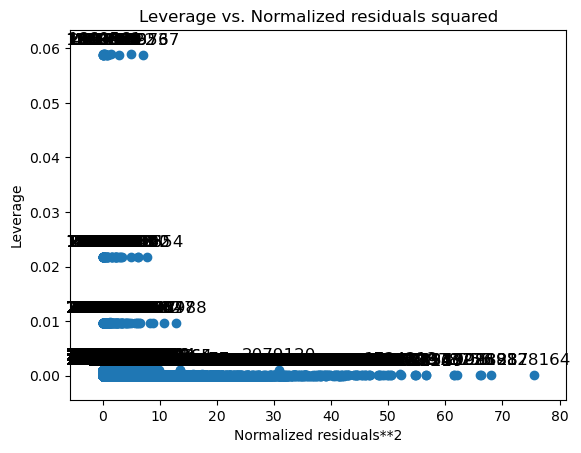

In [403]:
# Check for over levereged points, or anything else to be cleaned up.

sm.graphics.plot_leverage_resid2(resS)
plt.show()

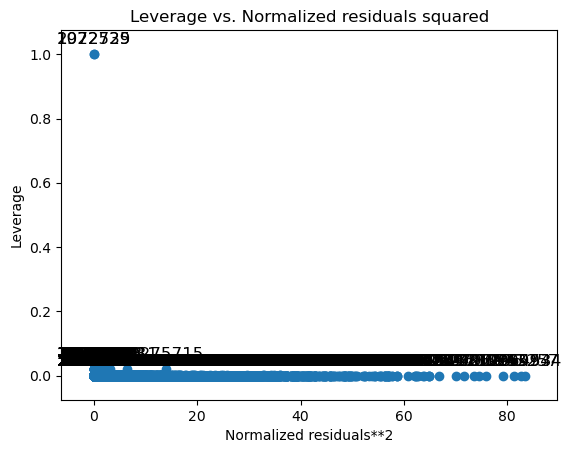

In [404]:
sm.graphics.plot_leverage_resid2(resB)
plt.show()

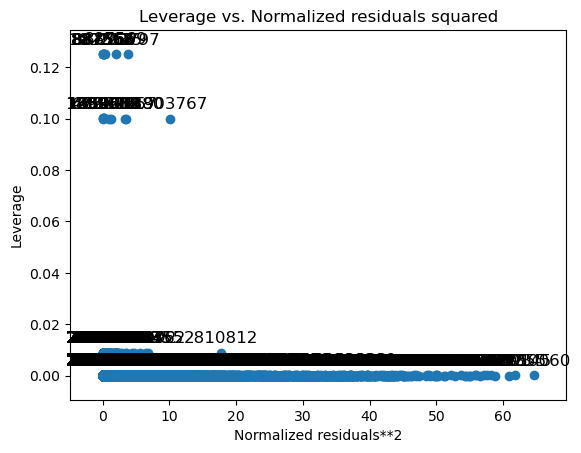

In [405]:
sm.graphics.plot_leverage_resid2(resD)
plt.show()

## Leveraged Points
- The bench model has two levereged points, but their normalized residuals are extremely small so their impact via removal is also going to be relatively small. Therefore, we will leave them in and proceed to use the test data to verify the models.

In [406]:
S1Tmodel = smf.ols(formula='Best3SquatKg ~ Sex + Event + Equipment + Age + BodyweightKg + Tested', data=S1_test) 
resS2T = S1Tmodel.fit()
print(resS2T.summary())

                            OLS Regression Results                            
Dep. Variable:           Best3SquatKg   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.597
Method:                 Least Squares   F-statistic:                     8917.
Date:                Sat, 29 Apr 2023   Prob (F-statistic):               0.00
Time:                        23:15:34   Log-Likelihood:            -3.7928e+05
No. Observations:               72300   AIC:                         7.586e+05
Df Residuals:                   72287   BIC:                         7.587e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [407]:
B1Tmodel = smf.ols(formula='Best3BenchKg ~ Sex + Event + Equipment + Age + BodyweightKg + Tested', data=B1_test) 
resBT = B1Tmodel.fit()
print(resBT.summary())

                            OLS Regression Results                            
Dep. Variable:           Best3BenchKg   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                 1.737e+04
Date:                Sat, 29 Apr 2023   Prob (F-statistic):               0.00
Time:                        23:15:35   Log-Likelihood:            -5.0553e+05
No. Observations:              102739   AIC:                         1.011e+06
Df Residuals:                  102727   BIC:                         1.011e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [408]:
D1Tmodel = smf.ols(formula='Best3DeadliftKg ~ Sex + Event + Equipment + Age + BodyweightKg + Tested', data=D1_test) 
resDT = D1Tmodel.fit()
print(resDT.summary())

                            OLS Regression Results                            
Dep. Variable:        Best3DeadliftKg   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                 1.051e+04
Date:                Sat, 29 Apr 2023   Prob (F-statistic):               0.00
Time:                        23:15:35   Log-Likelihood:            -4.1649e+05
No. Observations:               81270   AIC:                         8.330e+05
Df Residuals:                   81258   BIC:                         8.331e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

The resulting $R^2$ values are very similar between the train and test data, and this is mostly unsurprising due to the sheer volume of samples.  The test data produces a very slightly lower adjusted $R^2$ value.

# Multicollinearity
- It would be difficult to use these linear regression models to truly account for multicollinearity, but some of it is also part of the predictions.
- Heavier lifters typically lift more, older lifters typically lift less etc.

# Random Forest Model
- This model should help the issue of multicollinearity
- It also will hopefully provide a good basis for possible predictions.

In [409]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [410]:
# For the Random Forest Model, I will be dropping out all the data not used in the previous regression models
squatdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361500 entries, 320 to 2879524
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Sex               361500 non-null  object 
 1   Event             361500 non-null  object 
 2   Equipment         361500 non-null  object 
 3   Age               361500 non-null  float64
 4   Division          361500 non-null  object 
 5   BodyweightKg      361500 non-null  float64
 6   Best3SquatKg      361500 non-null  float64
 7   Tested            361500 non-null  int64  
 8   Country           361500 non-null  object 
 9   Federation        361500 non-null  object 
 10  ParentFederation  361500 non-null  object 
 11  Date              361500 non-null  object 
 12  MeetCountry       361500 non-null  object 
 13  MeetState         361500 non-null  object 
 14  MeetTown          361500 non-null  object 
 15  MeetName          361500 non-null  object 
dtypes: float64(3), in

In [411]:
squatdata = squatdata.drop(['Division', 'Country', 'Federation', 'ParentFederation', 'Date', 'MeetCountry', 'MeetState', 'MeetTown', 'MeetName'], axis = 1)
benchdata = benchdata.drop(['Division', 'Country', 'Federation', 'ParentFederation', 'Date', 'MeetCountry', 'MeetState', 'MeetTown', 'MeetName'], axis = 1)
deadliftdata = deadliftdata.drop(['Division', 'Country', 'Federation', 'ParentFederation', 'Date', 'MeetCountry', 'MeetState', 'MeetTown', 'MeetName'], axis = 1)

In [412]:
squatdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361500 entries, 320 to 2879524
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Sex           361500 non-null  object 
 1   Event         361500 non-null  object 
 2   Equipment     361500 non-null  object 
 3   Age           361500 non-null  float64
 4   BodyweightKg  361500 non-null  float64
 5   Best3SquatKg  361500 non-null  float64
 6   Tested        361500 non-null  int64  
dtypes: float64(3), int64(1), object(3)
memory usage: 22.1+ MB


In [413]:
# Need dummy vars to fit in sklearn
squatdata = pd.get_dummies(squatdata, prefix=['Sex', 'Event', 'Equip'], columns=['Sex', 'Event', 'Equipment'])
benchdata = pd.get_dummies(benchdata, prefix=['Sex', 'Event', 'Equip'], columns=['Sex', 'Event', 'Equipment'])
deadliftdata = pd.get_dummies(deadliftdata, prefix=['Sex', 'Event', 'Equip'], columns=['Sex', 'Event', 'Equipment'])

In [414]:
squatdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361500 entries, 320 to 2879524
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Age               361500 non-null  float64
 1   BodyweightKg      361500 non-null  float64
 2   Best3SquatKg      361500 non-null  float64
 3   Tested            361500 non-null  int64  
 4   Sex_F             361500 non-null  uint8  
 5   Sex_M             361500 non-null  uint8  
 6   Event_S           361500 non-null  uint8  
 7   Event_SB          361500 non-null  uint8  
 8   Event_SBD         361500 non-null  uint8  
 9   Event_SD          361500 non-null  uint8  
 10  Equip_Multi-ply   361500 non-null  uint8  
 11  Equip_Raw         361500 non-null  uint8  
 12  Equip_Single-ply  361500 non-null  uint8  
 13  Equip_Straps      361500 non-null  uint8  
 14  Equip_Unlimited   361500 non-null  uint8  
 15  Equip_Wraps       361500 non-null  uint8  
dtypes: float64(3), in

In [416]:
benchdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 513692 entries, 214 to 2880859
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Age               513692 non-null  float64
 1   BodyweightKg      513692 non-null  float64
 2   Best3BenchKg      513692 non-null  float64
 3   Tested            513692 non-null  int64  
 4   Sex_F             513692 non-null  uint8  
 5   Sex_M             513692 non-null  uint8  
 6   Sex_Mx            513692 non-null  uint8  
 7   Event_B           513692 non-null  uint8  
 8   Event_BD          513692 non-null  uint8  
 9   Event_SB          513692 non-null  uint8  
 10  Event_SBD         513692 non-null  uint8  
 11  Equip_Multi-ply   513692 non-null  uint8  
 12  Equip_Raw         513692 non-null  uint8  
 13  Equip_Single-ply  513692 non-null  uint8  
 14  Equip_Straps      513692 non-null  uint8  
 15  Equip_Unlimited   513692 non-null  uint8  
 16  Equip_Wraps      

In [417]:
deadliftdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406349 entries, 272 to 2879525
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Age               406349 non-null  float64
 1   BodyweightKg      406349 non-null  float64
 2   Best3DeadliftKg   406349 non-null  float64
 3   Tested            406349 non-null  int64  
 4   Sex_F             406349 non-null  uint8  
 5   Sex_M             406349 non-null  uint8  
 6   Event_BD          406349 non-null  uint8  
 7   Event_D           406349 non-null  uint8  
 8   Event_SBD         406349 non-null  uint8  
 9   Event_SD          406349 non-null  uint8  
 10  Equip_Multi-ply   406349 non-null  uint8  
 11  Equip_Raw         406349 non-null  uint8  
 12  Equip_Single-ply  406349 non-null  uint8  
 13  Equip_Straps      406349 non-null  uint8  
 14  Equip_Unlimited   406349 non-null  uint8  
 15  Equip_Wraps       406349 non-null  uint8  
dtypes: float64(3), in

In [419]:
# Setting up feature and target variables for the 3 RF models that need to be made.
featuresS = ['Sex_F', 'Sex_M', 'Event_S', 'Event_SB', 'Event_SBD', 'Event_SD', 'Equip_Multi-ply', 'Equip_Raw', 'Equip_Single-ply', 'Equip_Straps', 'Equip_Unlimited', 'Equip_Wraps', 'Age', 'BodyweightKg', 'Tested']
featuresB = ['Sex_F', 'Sex_M', 'Event_B', 'Event_BD', 'Event_SBD', 'Event_SB', 'Equip_Multi-ply', 'Equip_Raw', 'Equip_Single-ply', 'Equip_Straps', 'Equip_Unlimited', 'Equip_Wraps', 'Age', 'BodyweightKg', 'Tested']
featuresD = ['Sex_F', 'Sex_M', 'Event_BD', 'Event_D', 'Event_SBD', 'Event_SD', 'Equip_Multi-ply', 'Equip_Raw', 'Equip_Single-ply', 'Equip_Straps', 'Equip_Unlimited', 'Equip_Wraps', 'Age', 'BodyweightKg', 'Tested']
XS = squatdata.loc [:, featuresS]
XB = benchdata.loc [:, featuresB]
XD = deadliftdata.loc [:, featuresD]
yS = squatdata.loc [:, 'Best3SquatKg']
yB = benchdata.loc [:, 'Best3BenchKg']
yD = deadliftdata.loc [:, 'Best3DeadliftKg']

# Splitting data into 3 seperate train/test sets
XS_train, XS_test, yS_train, yS_test = train_test_split(XS, yS, train_size = .8, random_state = 5)
XB_train, XB_test, yB_train, yB_test = train_test_split(XB, yB, train_size = .8, random_state = 5)
XD_train, XD_test, yD_train, yD_test = train_test_split(XD, yD, train_size = .8, random_state = 5)

In [431]:
regS = RandomForestRegressor(max_depth = 10, random_state = 5)
regB = RandomForestRegressor(max_depth = 10, random_state = 5)
regD = RandomForestRegressor(max_depth = 10, random_state = 5)

In [432]:
# Training the models... My poor CPU :(

RFS = regS.fit(XS_train, yS_train)
RFB = regB.fit(XB_train, yB_train)
RFD = regD.fit(XD_train, yD_train)

In [435]:
print(RFS.score(XS_test, yS_test))
print(RFB.score(XB_test, yB_test))
print(RFD.score(XD_test, yD_test))

0.6826971661632804
0.7451027355671347
0.6899186275682841


# Score
- At depth 10 it fits surprisingly well in all 3 models. I will attempt to tune the hyperparameter, but bearing in mind that I will only go up to depth 15 because otherwise my computer may explode. 

In [436]:
max_depth_range = list(range(1, 15))
# List to store the average RMSE for each value of max_depth:
r2_list = []
for depth in max_depth_range:
    regS = RandomForestRegressor(max_depth = depth,
                            random_state = 0)
    regS.fit(XS_train, yS_train)   
    
    score = regS.score(XS_test, yS_test)
    r2_list.append(score)

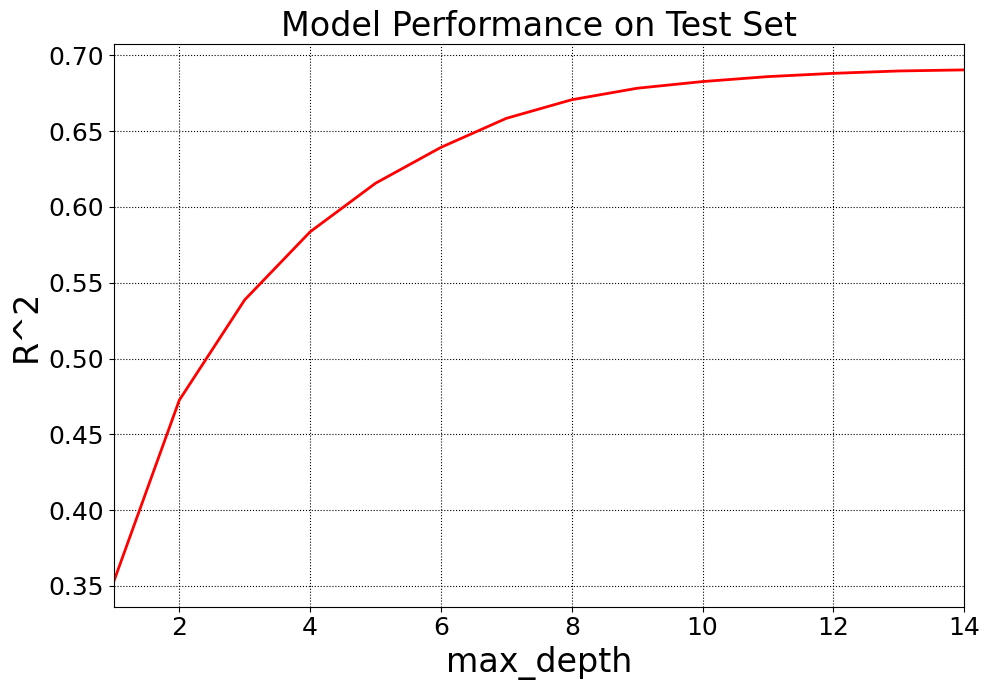

In [437]:
fig, ax = plt.subplots(nrows = 1, ncols = 1,
                       figsize = (10,7),
                       facecolor = 'white');
ax.plot(max_depth_range,
       r2_list,
       lw=2,
       color='r')
ax.set_xlim([1, max(max_depth_range)])
ax.grid(True,
       axis = 'both',
       zorder = 0,
       linestyle = ':',
       color = 'k')
ax.tick_params(labelsize = 18)
ax.set_xlabel('max_depth', fontsize = 24)
ax.set_ylabel('R^2', fontsize = 24)
ax.set_title('Model Performance on Test Set', fontsize = 24)
fig.tight_layout()

- I'll call it a lucky guess, but based on the graphic above a max depth of 10 does not seem unreasonable for the model. 

In [438]:
max_depth_range = list(range(1, 15))
# List to store the average RMSE for each value of max_depth:
r2_list = []
for depth in max_depth_range:
    regB = RandomForestRegressor(max_depth = depth,
                            random_state = 0)
    regB.fit(XB_train, yB_train)   
    
    score = regB.score(XB_test, yB_test)
    r2_list.append(score)

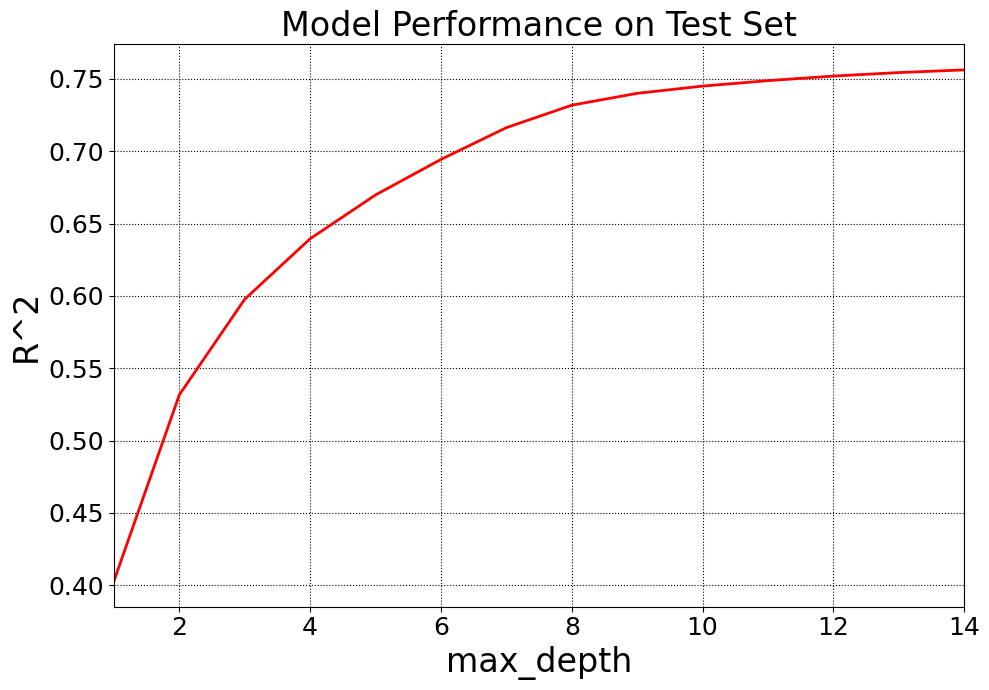

In [439]:
fig, ax = plt.subplots(nrows = 1, ncols = 1,
                       figsize = (10,7),
                       facecolor = 'white');
ax.plot(max_depth_range,
       r2_list,
       lw=2,
       color='r')
ax.set_xlim([1, max(max_depth_range)])
ax.grid(True,
       axis = 'both',
       zorder = 0,
       linestyle = ':',
       color = 'k')
ax.tick_params(labelsize = 18)
ax.set_xlabel('max_depth', fontsize = 24)
ax.set_ylabel('R^2', fontsize = 24)
ax.set_title('Model Performance on Test Set', fontsize = 24)
fig.tight_layout()

In [441]:
max_depth_range = list(range(1, 15))
# List to store the average RMSE for each value of max_depth:
r2_list = []
for depth in max_depth_range:
    regD = RandomForestRegressor(max_depth = depth,
                            random_state = 0)
    regD.fit(XD_train, yD_train)   
    
    score = regD.score(XD_test, yD_test)
    r2_list.append(score)

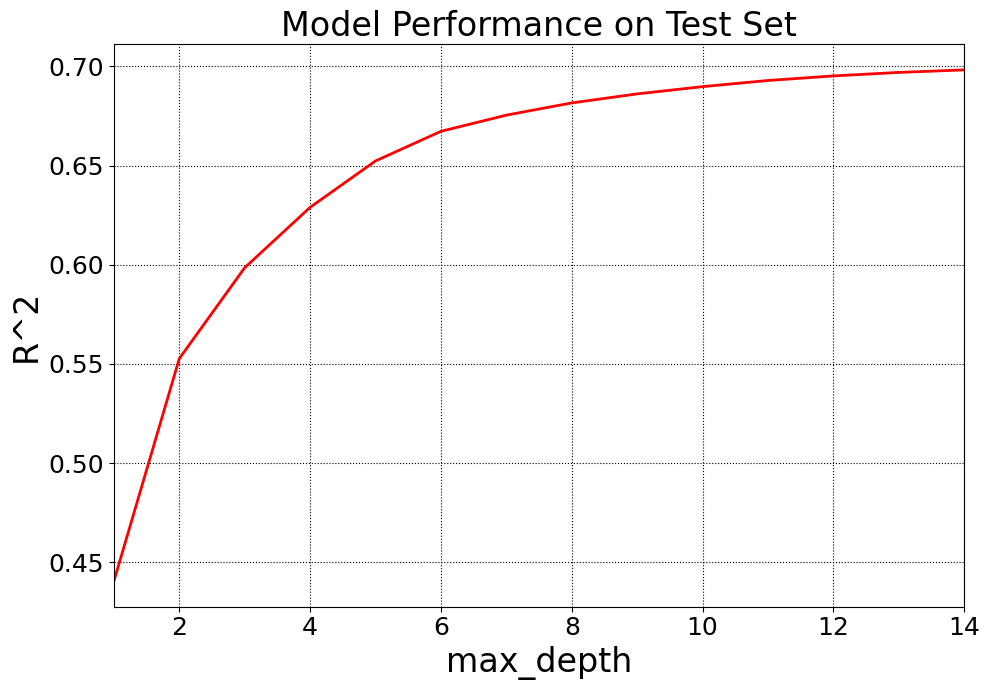

In [442]:
fig, ax = plt.subplots(nrows = 1, ncols = 1,
                       figsize = (10,7),
                       facecolor = 'white');
ax.plot(max_depth_range,
       r2_list,
       lw=2,
       color='r')
ax.set_xlim([1, max(max_depth_range)])
ax.grid(True,
       axis = 'both',
       zorder = 0,
       linestyle = ':',
       color = 'k')
ax.tick_params(labelsize = 18)
ax.set_xlabel('max_depth', fontsize = 24)
ax.set_ylabel('R^2', fontsize = 24)
ax.set_title('Model Performance on Test Set', fontsize = 24)
fig.tight_layout()

Overall, for all models, a depth of 10 seems reasonable.

In [443]:
# Graph predicted on original data
ypredS = RFS.predict(XS_test)
ypredB = RFB.predict(XB_test)
ypredD = RFD.predict(XD_test)

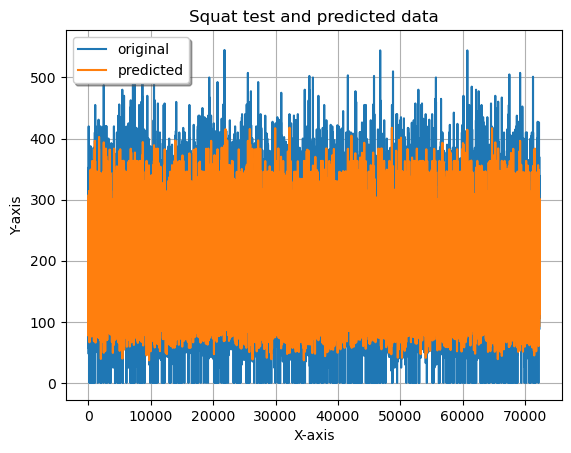

In [451]:
x_ax = range(len(yS_test))
plt.plot(x_ax, yS_test, label="original")
plt.plot(x_ax, ypredS, label="predicted")
plt.title("Squat test and predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

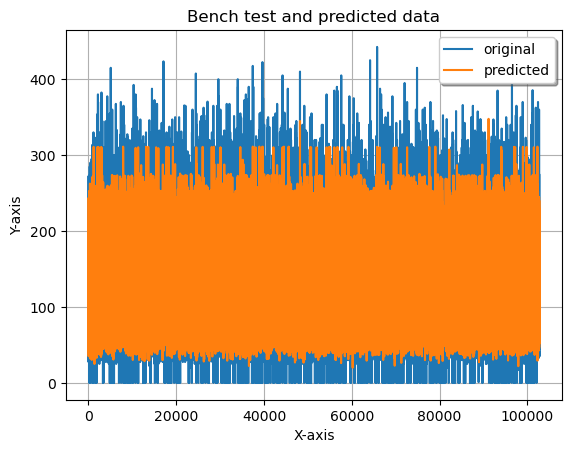

In [452]:
x_ax = range(len(yB_test))
plt.plot(x_ax, yB_test, label="original")
plt.plot(x_ax, ypredB, label="predicted")
plt.title("Bench test and predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

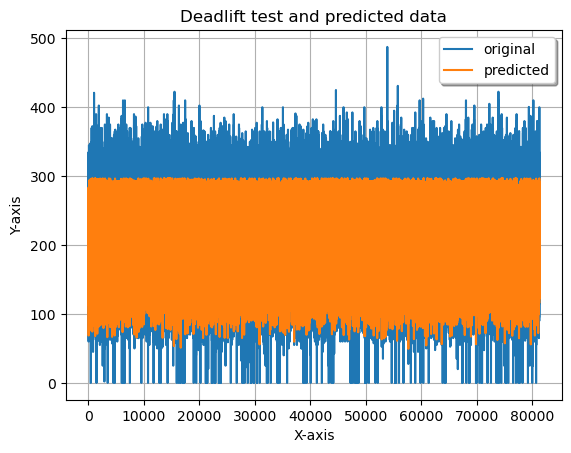

In [453]:
x_ax = range(len(yD_test))
plt.plot(x_ax, yD_test, label="original")
plt.plot(x_ax, ypredD, label="predicted")
plt.title("Deadlift test and predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

# Results
- Overall, all 3 random forest models fit significantly better than the multiple linear regression models. 
    - This was expected due to the multicollinearity that existed previously.
        - Visualizations are shown above and will not be redrawn to avoid clutter.
- As shown above, multiple iterations were attempted, features dropped as needed, and some features engineered to be more useful or usable in the case of the Random Forest Models
    - The final set of features were (Sex + Event + Equipment + Age + BodyweightKg + Tested) for a total of 6 features, which is down significantly from the 41 (38 not including test variables) features initially.
    - I got fairly lucky in guessing that a max depth of 10 for the RF models would be good, but I was able to confirm it and so did not have to tune my hyperparameter.
- Linear regression models
    - $R^2$ Values:
        - Squats: 0.595
        - Bench: 0.650
        - Deadlift: 0.587
- Random Forest models
    - $R^2$ Values:
        - Squats: 0.683
        - Bench: 0.745
        - Deadlift: 0.690

- Looking at the random forest graphs of predicted vs original, all 3 predictions appear to be more centered than the actual data. This might have something to do with failed lifts being counted as 0. 
    - A weird difference between Deadlifts and the other 2 is that the predictions appear to cap around 300. This could happen due to it trying to average in 0 values and deadlifts are typically a much higher weighted lift than the other two lifts.

# Conclusion
- The random forest models are the better models for use in predicting powerlifting results for any of the 3 major lifts as they fit the test data significantly better.
- Overall, in this project I learned how to use linear regression models to identify features that could be removed due to insignificance before creating a random forest model, and also a ton of different useful tricks + plots in Python.
    - An area of potential improvement for this model and this project is that the dataset is lacking a true classifier for the lifters. Lifters are broken into divisions, but there are far too many to be useful. It would be very helpful if lifters were classified based on their lifting experience. 
        - Personally, I am surprised that the random forest model has an $R^2$ close to 0.7 as I would expect it to be fairly difficult to predict powerlifting results. I know personally in the last year my numbers have changed drastically, but my weight has only slightly increased. 
- It would be really interesting to apply these models to another dataset and see if the numbers are still close.